In [7]:
import os
import requests

def save_and_cache(url, path, force=False):
    if not os.path.exists(path) or force:
        print(f"Downloading {url} to {path} ...")
        r = requests.get(url)
        with open(path, 'wb') as f:
            f.write(r.content)

# 疫情数据

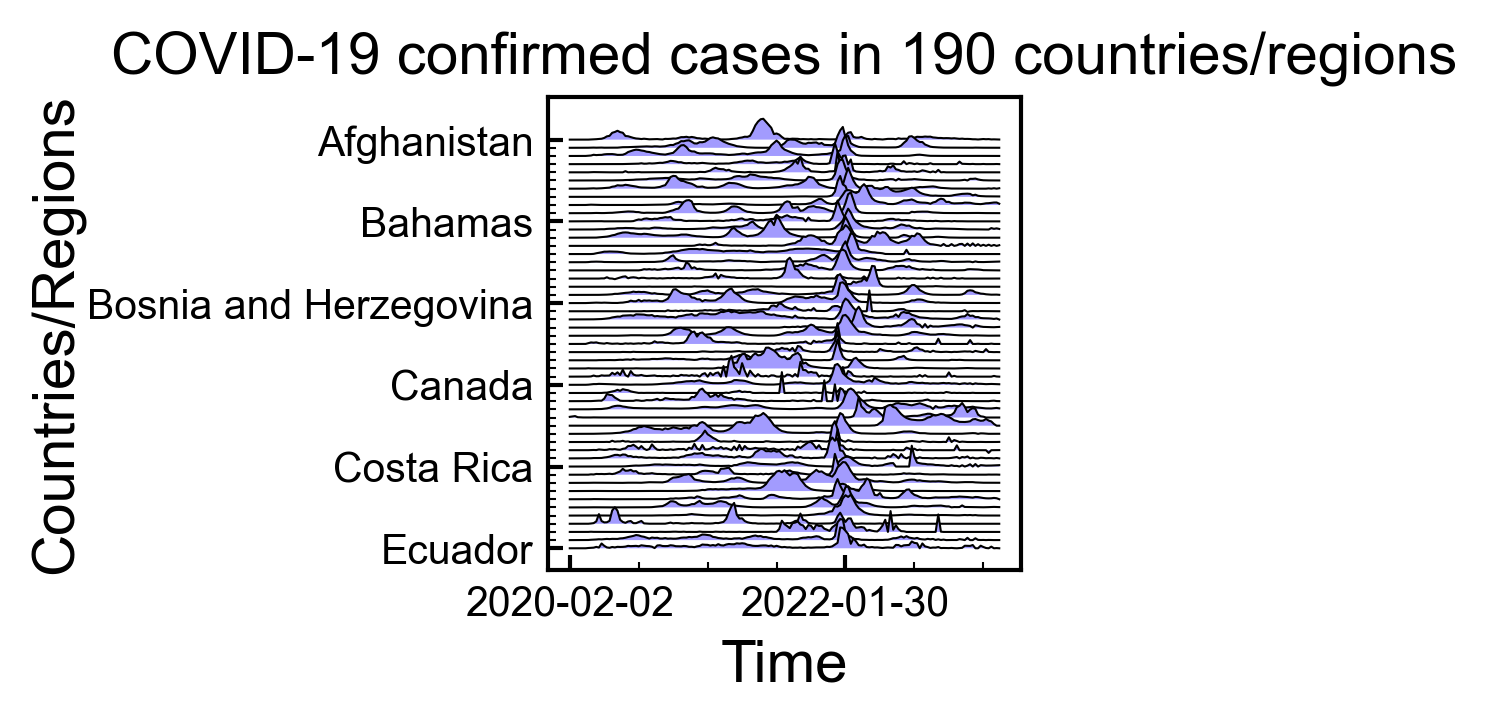

(190,) (163,) (163, 190)


In [8]:
import numpy as np
import pandas as pd

save_and_cache('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', '../data/epidemic/time_series_covid19_confirmed_global.csv')
df_world = pd.read_csv('../data/epidemic/time_series_covid19_confirmed_global.csv')
df_world.drop(columns=['Province/State', 'Lat', 'Long'], inplace=True)
df_world = df_world.groupby('Country/Region').sum()
df_world.rename(index={'Burma': 'Myanmar', 'Taiwan*': 'Chinese Taipei'}, inplace=True)
df_world.drop(index=['Antarctica', 'Diamond Princess', 'MS Zaandam', 'Summer Olympics 2020', 'Winter Olympics 2022', 'West Bank and Gaza', 'Andorra', 'Holy See', 'Kosovo', 'Liechtenstein', 'San Marino'], inplace=True) # drop non-country and mini country with no OD data
df_world.sort_index(inplace=True)

# 等间隔为 1 日
assert len(pd.to_datetime(df_world.columns.values, format='%m/%d/%y').diff()[1:].unique()) == 1
# 汇总为 1 周的数据
df_world.columns = pd.to_datetime(df_world.columns, format='%m/%d/%y')
df_world = df_world.T.resample('W').max().T # 这里是累计确诊数，所以取最大值作为本周累计确诊数

node = df_world.index.to_numpy() # (N,)
time = pd.to_datetime(df_world.columns.values, format='%m/%d/%y').astype(str).values[1:] # (T,)
case = np.diff(df_world.values.T, axis=0) # (T, N)

import matplotlib.pyplot as plt
from ND2.utils import get_fig, clear_svg
fi, fig, axes = get_fig(1, 1, AW=4, AH=4, lw=1.0, fontsize=14)

N = 51
N0 = 0
dN = 10
dT = 52 * 2
delta = -1
for idx, name in enumerate(node[:N]):
    scale = N / 20 / case[:, idx].max()
    axes[0].plot(case[:, idx] * scale + delta*idx, color='black', lw=fi.lw/2, zorder=idx)
    axes[0].fill_between(np.arange(len(time)), case[:, idx] * scale + delta*idx, delta*idx, color='#a29bfe', alpha=1.0, edgecolor=None, zorder=idx-0.1)
axes[0].set_xticks(np.arange(len(time))[::dT])
axes[0].set_xticks(np.arange(len(time))[::dT//4], minor=True)
axes[0].set_xticklabels(time[::dT], rotation=0, fontsize=0.7*fi.fontsize)
axes[0].set_xlabel('Time', fontsize=fi.fontsize)

axes[0].set_yticks(delta*np.arange(len(node))[N0:N:dN])
axes[0].set_yticks(delta*np.arange(len(node))[:N], minor=True)
axes[0].tick_params(axis='both', which='minor', width=fi.lw/2)
axes[0].set_yticklabels(node[N0:N:dN], fontsize=0.7*fi.fontsize)
# axes[0].set_yticklabels([], fontsize=fi.fontsize)
axes[0].set_ylabel('Countries/Regions', fontsize=fi.fontsize, labelpad=0.5)

axes[0].tick_params(axis='both', which='both', direction='in')
axes[0].set_title(f'COVID-19 confirmed cases in {len(node)} countries/regions', fontsize=fi.fontsize)
fig.savefig('../plot/epidemic/COVID19inWorld.png', dpi=300, transparent=True)
fig.savefig('../plot/epidemic/COVID19inWorld.svg', transparent=True)
clear_svg('../plot/epidemic/COVID19inWorld.svg')
plt.show()

print(node.shape, time.shape, case.shape)

In [9]:
node

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde',
       'Cambodia', 'Cameroon', 'Canada', 'Central African Republic',
       'Chad', 'Chile', 'China', 'Chinese Taipei', 'Colombia', 'Comoros',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada',
       'Guatemala', 'Guinea', 'Guinea-Bissau', 

In [10]:
len(node)

190

# 移动数据

In [11]:
import pandas as pd
from tqdm import tqdm

if os.path.exists('../data/epidemic/ODinWorld.csv'):
    df = pd.read_csv('../data/epidemic/ODinWorld.csv')
else:
    df_list = []
    for year in tqdm(range(2019, 2022)):
        for month in range(1, 13):
            try:
                # df = pd.read_parquet(f'processed/city_level_seats_and_price/2020-{month}.parquet.gz')
                df = pd.read_parquet(f'http://rl2.yumeow.site:8000/2020-{month}.parquet.gz')
                df = df[['Dep Country Name', 'Arr Country Name', 'Total Est. Pax']]
                df = df.groupby(['Dep Country Name', 'Arr Country Name']).sum().reset_index()
                df['Time Series'] = f'2020-{month:02}'
                df_list.append(df)
            except Exception as e:
                print(f'{year}-{month} not found ({e})')
                continue

    df = pd.concat(df_list)
    df.columns = ['source', 'destination', 'flow', 'time']
    mapping = {"Russian Federation": "Russia", "USA": "US", "Viet Nam": "Vietnam", "Iran Islamic Republic of": "Iran", "Ireland Republic of": "Ireland", "Korea Democratic People's Republic of": "Korea, North", "Korea Republic of": "Korea, South", "Lao People's Democratic Republic": "Laos", "Macao (sar) China": "China", "Hong Kong (sar) China": "China", "Antigua and Barbuda, Leeward Islands": "Antigua and Barbuda", "Brunei Darussalam": "Brunei", "Moldova Republic of": "Moldova", "Macedonia Former Yugoslav Republic of": "North Macedonia", "Micronesia Federated States of": "Micronesia", "Syrian Arab Republic": "Syria", "Tanzania United Republic of": "Tanzania", "Timor-leste": "Timor-Leste", "Saint Kitts and Nevis, Leeward Islands": "Saint Kitts and Nevis", "Grenada, Windward Islands": "Grenada", "Congo Democratic Republic of": "Congo (Kinshasa)", "Congo": "Congo (Brazzaville)", "Cote D'Ivoire": "Cote d'Ivoire", "Czech Republic": "Czechia", "Cape Verde": "Cabo Verde", "St Vincent and the Grenadines": "Saint Vincent and the Grenadines"}
    df['source'] = df['source'].replace(mapping)
    df['destination'] = df['destination'].replace(mapping)
    # 汇总
    df = df.groupby(['source', 'destination'])['flow'].sum().reset_index()
    df.to_csv('../data/epidemic/ODinWorld.csv', index=False)

df

,source,destination,flow
0,Afghanistan,Afghanistan,2777589
1,Afghanistan,Albania,177
2,Afghanistan,Angola,12
3,Afghanistan,Argentina,15
4,Afghanistan,Armenia,21
...,...,...,...
31165,Zimbabwe,Uruguay,54
31166,Zimbabwe,Uzbekistan,36
31167,Zimbabwe,Vietnam,84
31168,Zimbabwe,Zambia,104238


In [12]:
# 排除没有疫情数据的国家
df = df[df['source'].isin(node) & df['destination'].isin(node)]
# 排除自己到自己的流量
df = df[df['source'] != df['destination']]

assert all(np.sort(df['source'].unique()) == np.sort(node))
assert all(np.sort(df['destination'].unique()) == np.sort(node))

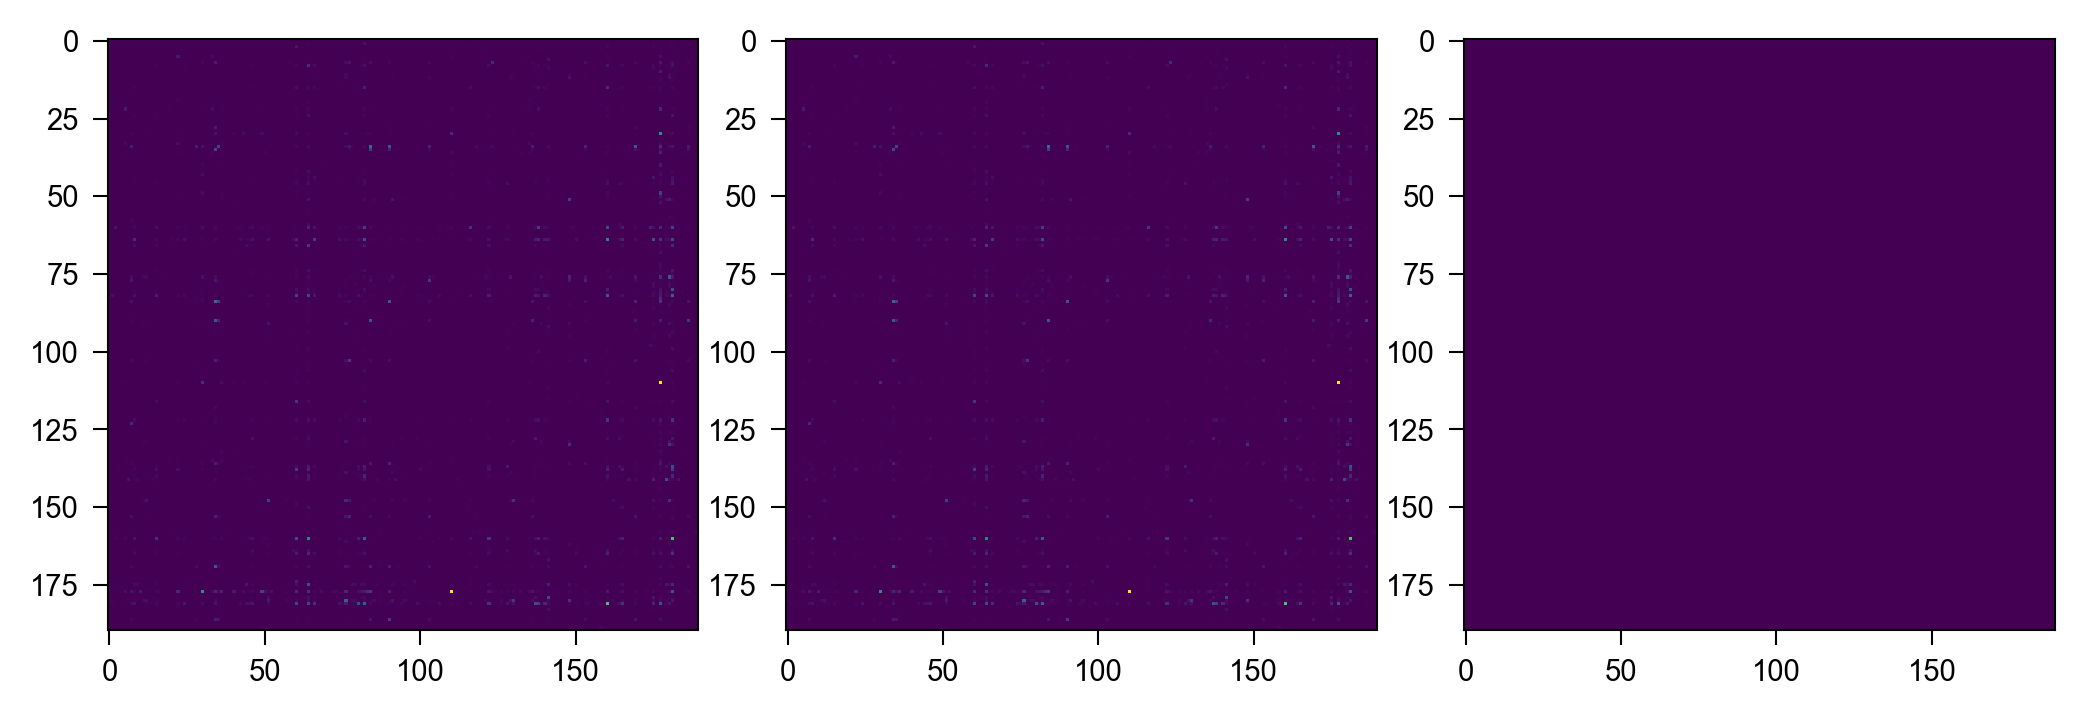

In [13]:
D = 20
df_sparse = df.copy()
df_sparse.sort_values('flow', ascending=False, inplace=True)
df_sparse = df_sparse[:D*len(node)]
df_sparse

from ND2.utils import get_fig
from matplotlib.colors import LogNorm, Normalize
fi, fig, axes = get_fig(1, 3, AW=5)
norm = Normalize(vmin=0, vmax=df['flow'].max())
pivot1 = df.pivot_table(index='source', columns='destination', values='flow', fill_value=0, aggfunc='sum').reindex(index=node, columns=node, fill_value=0)
pivot2 = df_sparse.pivot_table(index='source', columns='destination', values='flow', fill_value=0, aggfunc='sum').reindex(index=node, columns=node, fill_value=0)
axes[0].imshow(pivot1.values, norm=norm)
axes[1].imshow(pivot2.values, norm=norm)
axes[2].imshow(pivot1.values - pivot2.values, norm=norm)
plt.show()

In [14]:
df_sparse

,source,destination,flow
18502,Mexico,US,42908472
29039,US,Mexico,42228276
26359,Spain,United Kingdom,31130622
29893,United Kingdom,Spain,30764919
5073,Canada,US,22387683
...,...,...,...
13403,Iran,Denmark,51366
14767,Jordan,Philippines,51366
10202,France,Slovenia,51300
26157,South Sudan,United Arab Emirates,51258


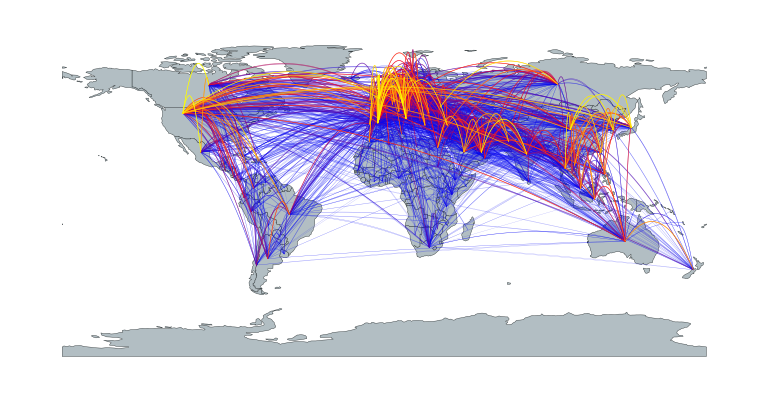

In [15]:
import geopandas as gpd
from ND2.utils.plot import get_fig, plotOD

data = df_sparse.copy()
data.columns = ['source', 'destination', 'flow']
save_and_cache('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip', '../data/epidemic/ne_110m_admin_0_countries.zip')
gdf = gpd.read_file('../data/epidemic/ne_110m_admin_0_countries.zip')
gdf['NAME'] = gdf['NAME'].replace({'United States of America': 'US', 'South Korea': 'Korea, South', 'North Korea': 'Korea, North', 'Republic of Serbia': 'Serbia', 'Congo': 'Congo (Brazzaville)', 'Dem. Rep. Congo': 'Congo (Kinshasa)', 'United Republic of Tanzania': 'Tanzania', 'eSwatini': 'Eswatini', 'The Bahamas': 'Bahamas', 'Taiwan': 'Chinese Taipei', 'S. Sudan': 'South Sudan', 'Dominican Rep.': 'Dominican Republic', 'Eq. Guinea': 'Equatorial Guinea', 'Bosnia and Herz.': 'Bosnia and Herzegovina', "Côte d'Ivoire": "Cote d'Ivoire", 'Solomon Is.': 'Solomon Islands', 'Central African Rep.': 'Central African Republic'})

fi, fig, axes = get_fig(1, 1, AW=3*2, A_ratio=1, LM=0, RM=0, BM=0, TM=0.0, lw=1.0, fontsize=14)
gdf.plot(ax=axes[0], color='#b2bec3', edgecolor='#2d3436', linewidth=0.1)
location = {row['NAME']: row['geometry'].centroid.coords[0] for _, row in gdf.iterrows()}
plotOD(axes[0], data['source'], data['destination'], data['flow'], location, linetype='parabola')
axes[0].axis('off')
fig.savefig('../plot/epidemic/ODinWorld.png', dpi=600, transparent=True)
fig.savefig('../plot/epidemic/ODinWorld.svg', transparent=True)

# 保存数据

In [16]:
import json

state2idx = {s:idx for idx, s in enumerate(node)}
df_sparse['source_idx'] = df_sparse['source'].map(state2idx).astype(int)
df_sparse['destination_idx'] = df_sparse['destination'].map(state2idx).astype(int)
G = df_sparse[['source_idx', 'destination_idx']].values
A = np.zeros((len(node), len(node)))
A[G[:, 0], G[:, 1]] = 1

save = {}
save['node'] = node.tolist() # (N,)
save['time'] = time.tolist() # (T,)
save['case'] = case.tolist() # (T, N)
save['flow'] = df_sparse['flow'].values.tolist() # (E,)
save['A'] = A.tolist() # (N, N)
save['G'] = G.tolist() # (E, 2)
with open('../data/epidemic/COVID19inWorld.json', 'w') as f:
    json.dump(save, f)

for key, value in save.items():
    print(f'{key:10} -> {np.array(value).shape}')

node       -> (190,)
time       -> (163,)
case       -> (163, 190)
flow       -> (3800,)
A          -> (190, 190)
G          -> (3800, 2)
